# Overwatch Leauge Data Analytics Final

This first code block imports the required libraries that we need for the project, as well as setting up some variables and functions that we will use through the project
    

In [3]:
#Import numpy, Pandas, and matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Improt the CSV and combine them into one large dataframe
data = pd.concat([pd.read_csv('data/phs_2020_1.csv'),pd.read_csv('data/phs_2020_2.csv')])
#Delete Start Time and Esports ID column as we do not need it for this project
del data["start_time"]
del data["esports_match_id"]

#Make some useful variables
#Create a variable containing all unique players, stats, and heroes in the game
allPlayers = data["player_name"].unique()
allStats = data["stat_name"].unique()
heroNames = data["hero_name"].unique()
teamNames = data["team_name"].unique()
#Create subcatagories for each of the heroes based on their classification in game
tankHeros = ["D.Va","Orisa","Reinhardt","Roadhog", "Sigma", "Winston", "Wrecking Ball", "Zarya"]
dpsHeros = ["Ashe","Bastion","Doomfist","Echo","Genji","Hanzo","Junkrat","McCree","Mei","Pharah","Reaper","Soldier: 76","Sombra","Symmetra","Torbjörn","Tracer","Widowmaker"]
supportHeros = ["Ana","Baptiste","Brigitte","Lúcio","Mercy","Moira","Zenyatta"]
#These stats are total stats, so they need to be adjusted with time (getPlayerData function does this automatically)
importantTotalStats = ["All Damage Done", "Damage Taken", "Deaths", "Final Blows", "Objective Kills", "Healing Done"]

#Returns a dataframe with the important stats for a specific player with respect to time
#Note that certian stats are tracked oddly in the dataset (i.e Hog Heal is not attributed to Healing Recieved) so be aware of that
def getPlayerData(playerName):
    #Get the dataframe containing only stats from the specified player
    playerFrame = data[data.player_name == playerName]
    #Set up the returned data frame, where the index is each indivisual hero
    returnFrame = pd.DataFrame(index=playerFrame["hero_name"].unique())
    #Creates the time data frame, which keeps track of the time for each character, in intervals of 10 minutes
    timeFrame = playerFrame[playerFrame.stat_name == "Time Played"]  
    timeFrame = timeFrame.groupby(timeFrame["hero_name"]).sum()
    timeFrame = timeFrame / 600
    #For each of the important stats, filter the frame by that stat, group it by hero and find the total amount of each stat, then divide it by the time frame to get the stat epr 10 minutes
    for stat in importantTotalStats:
        tempFrame = playerFrame[playerFrame.stat_name == stat]  
        tempFrame = tempFrame.groupby(tempFrame["hero_name"]).sum()
        tempFrame = tempFrame / timeFrame
        returnFrame[stat] = tempFrame["stat_amount"]
    #Drop any rows that contain all null values, meaning that the player has never played that hero
    returnFrame = returnFrame.dropna(how='all')
    #In rows that only contain some null values, replace that null value with zero, as null values there mean that the player has never obtained that stat
    return returnFrame.fillna(0)
#Return a dataframe that contains the total seconds a hero was played for in the leauge
def totalHeroTime():
    timeFrame = data[data.stat_name == "Time Played"]  
    timeFrame = timeFrame.groupby(timeFrame["hero_name"]).sum()
    return timeFrame
#Given a specific stat and team, the function will return the average stat inserted for the team adjusted per 10 minutes
def getTeamStat(teamName, statName):
    #Filter the main dataFrame to only contain stats from the specified team
    teamStat = data[data.team_name == teamName]
    #Filter out values so that the frame is for All Heroes
    teamStat = teamStat[teamStat.hero_name == "All Heroes"]
    #Drop Null rows in the frame
    teamStat = teamStat.dropna()
    #Create the time played frame by player, in the same interval as the getPlayerData function
    timeStat = teamStat[teamStat.stat_name == "Time Played"]
    timeStat = timeStat.groupby(timeStat["player_name"]).sum()
    timeStat = timeStat / 600
    #Filter the stat
    teamStat = teamStat[teamStat.stat_name == statName]
    #Group each stat by player and sum all of the values
    teamStat = teamStat.groupby(teamStat["player_name"]).sum()
    #Adjust stat for time
    teamStat = teamStat / timeStat
    #Return the average value for that team in a 1x1 dataframe for easy manipulation
    return pd.DataFrame(data = teamStat.mean()[0] ,columns = [statName], index = [teamName])

## The majority of the data processing for our project, which is finding each players stats that are time adjusted to make it comparable to other players ##

In [4]:
#Make a List containing dataFrames of each player's important stats
adjustedData = {}
#For each unique player, get their stat and add it to the list
for player in allPlayers:
    adjustedData[player] = getPlayerData(player)

## Top 10 players with the highest stats per 10 minutes ##

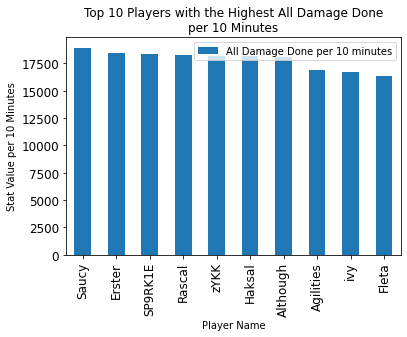

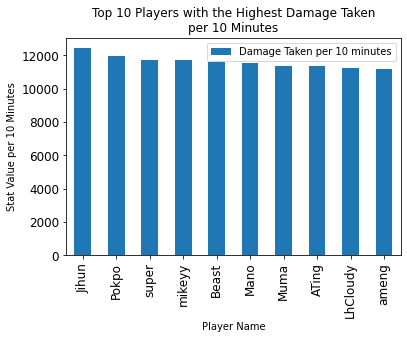

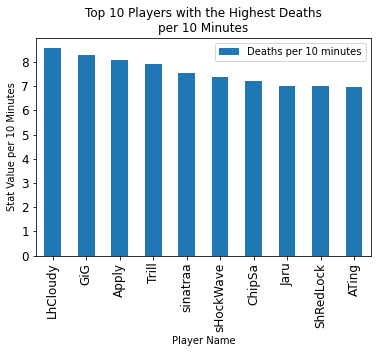

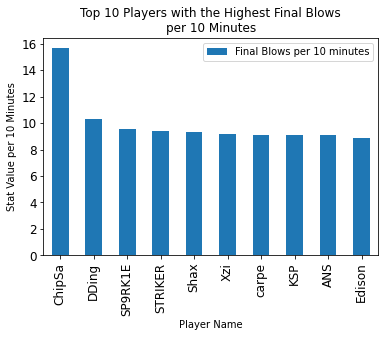

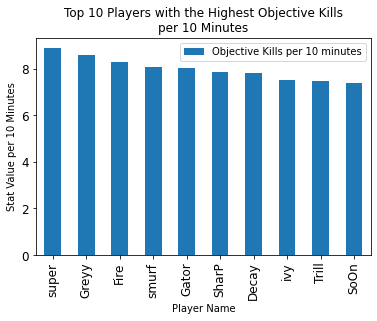

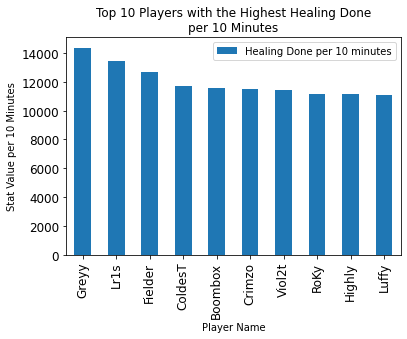

In [5]:
#Create a graph for each stat showing the top 10 players with that specific stat
#For each important stat, create a dictionary for each stat made up of the stats of each unique player
for stat in importantTotalStats:
    statValues = {}
    for player in allPlayers:
        statValues[player] = adjustedData[player].loc[["All Heroes"]][stat].values.item()
    #Convert the dictionary into a dataframe
    statFrame = pd.DataFrame.from_dict(statValues, orient = 'index', columns = [stat + " per 10 minutes"])
    #Sort the dataframe to get the 10 highest stats
    statFrame = statFrame.sort_values(by=[stat + " per 10 minutes"], ascending = False)
    #Filter down to the top 10 players
    statFrame = statFrame.iloc[0:10]
    #Plot the dataframe
    statFrame.plot(kind='bar', xlabel = "Player Name", ylabel = "Stat Value per 10 Minutes", title = "Top 10 Players with the Highest " + stat + "\nper 10 Minutes", fontsize = 12)

## Top 5 most played Heroes in each role ##

<AxesSubplot:title={'center':'Top 5 Most Played Tank Heroes'}, xlabel='Hero Name', ylabel='Time played in seconds'>

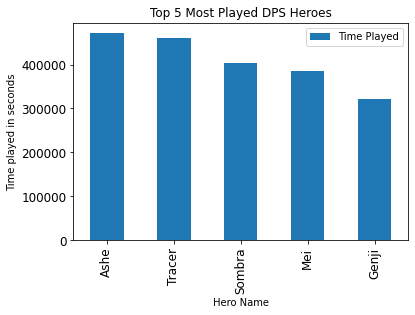

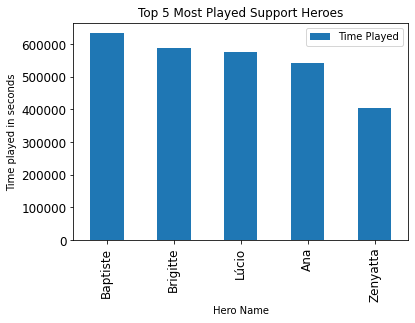

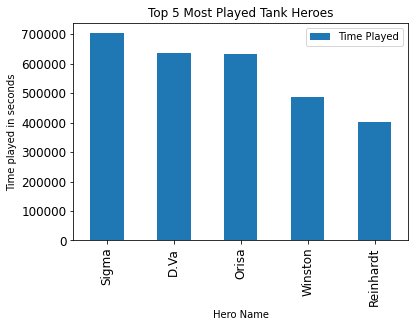

In [6]:
#Get the total time played for each hero
df = totalHeroTime()
#Filter this into three dataframes, one for each hero categoty
dpsHeroTime = df.reindex(dpsHeros, axis=0)
supportHeroTime = df.reindex(supportHeros, axis=0)
tankHeroTime = df.reindex(tankHeros, axis=0)
#Rename the column, Sort each frame, and get the top five for each frame to prepare for plotting
dpsHeroTime.rename(columns={"stat_amount":"Time Played"}, inplace = True)
supportHeroTime.rename(columns={"stat_amount":"Time Played"}, inplace = True)
tankHeroTime.rename(columns={"stat_amount":"Time Played"}, inplace = True)
dpsHeroTime = dpsHeroTime.sort_values(by=["Time Played"], ascending = False)
dpsHeroTime = dpsHeroTime.iloc[0:5]
supportHeroTime = supportHeroTime.sort_values(by=["Time Played"], ascending = False)
supportHeroTime = supportHeroTime.iloc[0:5]
tankHeroTime = tankHeroTime.sort_values(by=["Time Played"], ascending = False)
tankHeroTime = tankHeroTime.iloc[0:5]
#Create the graph for each hero group
dpsHeroTime.plot(kind='bar', xlabel = "Hero Name", ylabel = "Time played in seconds", title = "Top 5 Most Played DPS Heroes", fontsize = 12)
supportHeroTime.plot(kind='bar', xlabel = "Hero Name", ylabel = "Time played in seconds", title = "Top 5 Most Played Support Heroes", fontsize = 12)
tankHeroTime.plot(kind='bar', xlabel = "Hero Name", ylabel = "Time played in seconds", title = "Top 5 Most Played Tank Heroes", fontsize = 12)

## Adjusted Stats by Team (Averaging stats from all players on the team) ##

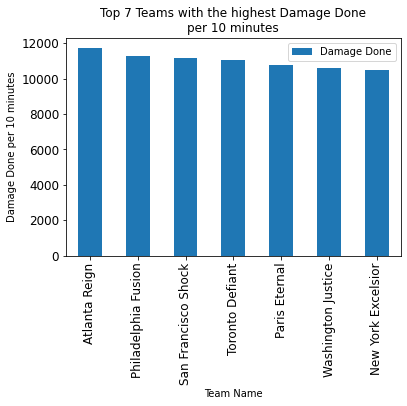

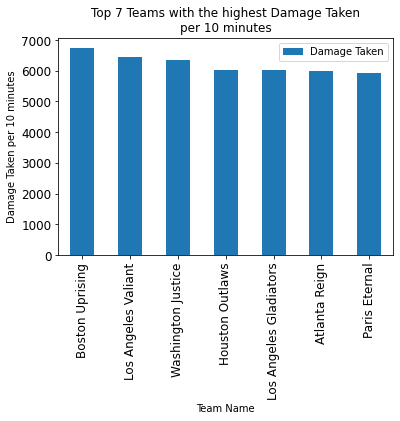

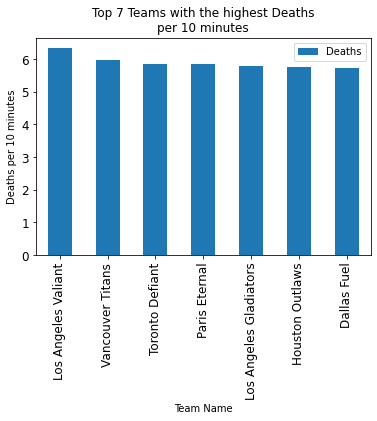

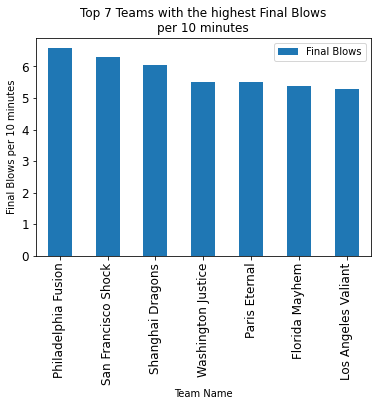

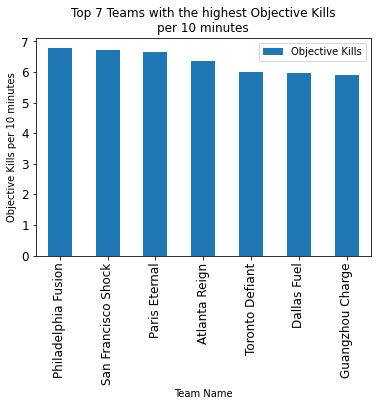

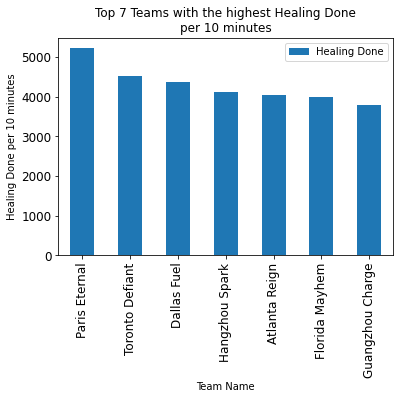

In [7]:
#Create a graph for each important stat
for stat in importantTotalStats:
    #Set up the dataframe we will plot
    allTeamStats = pd.DataFrame()
    #Add each team to the plotted dataframe
    for team in teamNames:
        allTeamStats = allTeamStats.append(getTeamStat(team, stat))
    #Rename the all Damage Done stat to Damage done for better readability
    if stat == "All Damage Done":
        localName = "Damage Done"
    else:
        localName = stat
    #Prepare the dataframe for graphing
    allTeamStats.rename(columns={stat:localName}, inplace = True)
    allTeamStats = allTeamStats.sort_values(by=[localName], ascending = False)
    allTeamStats = allTeamStats.iloc[0:7]
    #Graph the dataframe
    allTeamStats.plot(kind='bar', xlabel = "Team Name", ylabel = localName + " per 10 minutes", title = "Top 7 Teams with the highest " + localName + "\nper 10 minutes", fontsize = 12)


## Correlation plots to see if two stats are related to each other

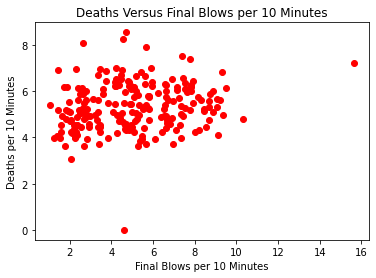

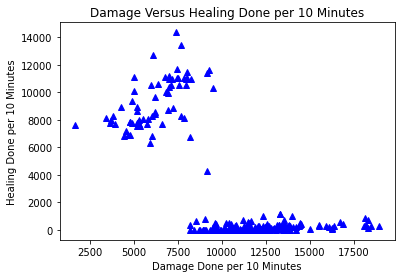

In [8]:
#Create the data list for each graph
graph1DataX = []
graph1DataY = []
graph2DataX = []
graph2DataY = []
#For each player, add their stat to the graphdata
for player in allPlayers:
    playerDat = adjustedData[player]
    col = playerDat.loc["All Heroes"]
    graph1DataX.append(col["Final Blows"])
    graph1DataY.append(col["Deaths"])
    graph2DataX.append(col["All Damage Done"])
    graph2DataY.append(col["Healing Done"])
#Format and plot each graph
plt.xlabel("Final Blows per 10 Minutes")
plt.ylabel("Deaths per 10 Minutes")
plt.title("Deaths Versus Final Blows per 10 Minutes")
plt.plot(graph1DataX,graph1DataY, 'ro')
plt.show()
plt.xlabel("Damage Done per 10 Minutes")
plt.ylabel("Healing Done per 10 Minutes")
plt.title("Damage Versus Healing Done per 10 Minutes")
plt.plot(graph2DataX,graph2DataY, 'b^')
plt.show()

 ## Pie charts for time played

array([<AxesSubplot:>], dtype=object)

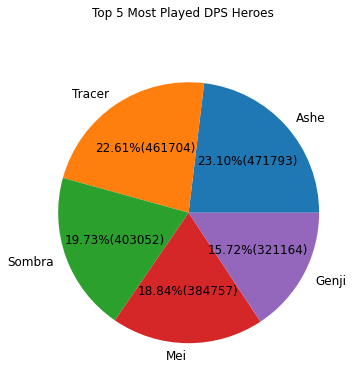

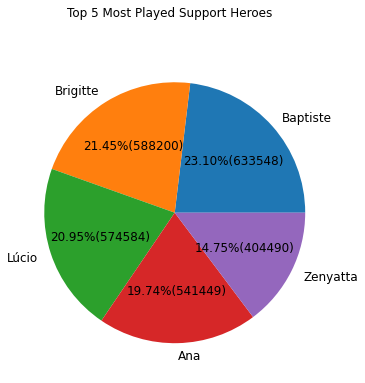

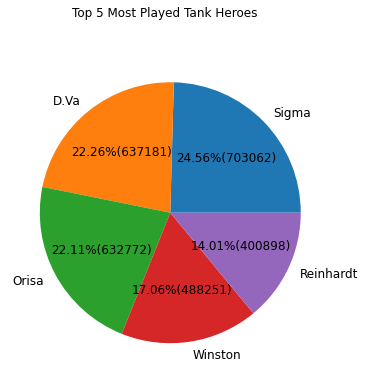

In [9]:
#For each of the categories, create a pie chart for time played
dpsHeroTime.plot(kind='pie', subplots=True, title = "Top 5 Most Played DPS Heroes", ylabel='', fontsize = 12, autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*sum(dpsHeroTime['Time Played'])), legend = False, figsize=[6,6])
supportHeroTime.plot(kind='pie', subplots=True, title = "Top 5 Most Played Support Heroes",ylabel='', fontsize = 12, autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*sum(supportHeroTime['Time Played'])), legend = False, figsize=[6,6])
tankHeroTime.plot(kind='pie', subplots=True, title = "Top 5 Most Played Tank Heroes",ylabel='', fontsize = 12, autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*sum(tankHeroTime['Time Played'])), legend = False, figsize=[6,6])